In [1]:
import os

import pandas as pd

from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from utils.ML.ML_extract_features import FeatureConstructor
from utils.ML.ML_experiment import ML_experiment

In [2]:
# # Import packages
# import os
import numpy as np
import pandas as pd
from scipy.stats import tvar, skew, kurtosis, entropy
from scipy.signal import welch, spectrogram
from scipy.integrate import simps
from tqdm import tqdm

from utils.dataloaders import OneSignal
# from utils import random_state
# # import random

# random_state(36)

class ML_Test:
    def __init__(self, data_name, predictor=None):
        """
        :param
            --data_name: filename like 'S001_128.mat' or tuple (data_path,label_path,peaks_path)
        """
        # Initialize class arguments
        self.data_name = data_name
        self.predictor = predictor

        # Get information for patient with data_name
        self.signal = OneSignal(data_name=self.data_name)
        # Filter the PPG signal
        self.signal.filter(fL = 0.5, fH = 4.3, order = 4)
        # Align onsets to determine crops: always 1 peak between 2 onsets
        self.signal.align_onsets()

        # Set attributes of FeatureExtractor
        self.ppg = self.signal.ppg              # get filtered ppg and derivatives
        self.vpg = self.signal.vpg
        self.apg = self.signal.apg
        self.jpg = self.signal.jpg
        self.fs = self.signal.fs                # sampling frequency                        --> int
        self.peaks = self.signal.peaks.flatten()# peaks array                               --> (number_of_peaks,)
        self.labels = self.signal.labels        # labels                                    --> (number_of_peaks,)
        self.onsets = self.signal.on            # determined by self.signal.align_onsets()  --> (number_of_peaks+1,)

        # Set crop creation status
        self.crop_creation = False


    def generate_crops(self):
        self.crops = []
        while self.signal.indx < self.signal.indx_max:
            # (x, y), (x_r, y_r) = self.signal.crop(raw=True)
            crop, _ = self.signal.crop(raw=False)
            self.crops.append(crop)

    # def initialize_dataframe(self):
    #     data = {

    #     }

    # def construct_features_one_crop(self, crop):
    #     return None

    

    def initialize_dataframe(self):
        ""
        self.feature_names = ['crop_duration','t_peak','mean','median','std','tvar','skew','kurt',
                              'auc','peak_amplitude','pulse_width','symmetry', 'spectral_entropy','average_energy',
                              'rmssd', 'std_spectrogram',
                              'PTP','A_to_N_ratio']
        # self.feature_names = ['crop_duration','t_peak','median','skew','kurt',
        #                       'auc','pulse_width','symmetry','spectral_entropy',
        #                       'PTP','A_to_N_ratio']
        
        features = np.zeros(((self.peaks.shape[0]), len(self.feature_names)))
        labels = np.empty(self.peaks.shape[0])
        labels[:] = None

        # Construct self.crops
        if self.crop_creation == False:
            self.generate_crops()
            self.crop_creation = True

        # Loop over all crops: intra-crop features
        for i, crop in enumerate(self.crops):
            features[i,:] = np.array(
                [crop.shape[0] / self.fs,
                 np.argmax(crop) / self.fs,
                 np.mean(crop),
                 np.median(crop),
                 np.std(crop),
                 tvar(crop), # tune values?
                 skew(crop),
                 kurtosis(crop),
                 simps(np.abs(crop), dx=1/self.fs), # AUC: Simpson's rule for numeral integration
                 np.max(crop)-np.min(crop),
                 self.pulse_width(crop),
                 self.symmetry_index(crop),
                 self.spectral_entropy(crop),
                 self.average_energy(crop),
                 self.rmssd(crop),
                 self.std_spectrogram(crop),
                 None,
                 None,
                 ])
                
                # [crop.shape[0] / self.fs,
                #  np.argmax(crop) / self.fs,
                #  np.median(crop),
                #  skew(crop),
                #  kurtosis(crop),
                #  simps(np.abs(crop), dx=1/self.fs), # AUC: Simpson's rule for numeral integration
                #  self.pulse_width(crop),
                #  self.symmetry_index(crop),
                #  self.spectral_entropy(crop),
                #  None,
                #  None,
                #  ])

        # Create a DataFrame
        data = {'peaks': self.peaks, 'labels': labels}
        for i, feature_name in enumerate(self.feature_names):
            data[feature_name] = features[:, i]

        # Inter-crop features
        self.df = pd.DataFrame(data)
        self.df['PTP'] = self.peak_to_peak_times()
        self.df['A_to_N_ratio'][0] = 0

        return self.df
    
    def apply_predictor(self):

        


        return self.df

    
    def get_inter_crop_features(self):
        ""
        self.ft_inter_crop_names = ['PTP','A_to_N_ratio']

        self.ft_inter_crop = np.zeros(((self.peaks.shape[0]), len(self.ft_inter_crop_names)))
        
        self.ft_inter_crop[:,0] = self.peak_to_peak_times()
        self.ft_inter_crop[:,1] = self.A_to_N_ratio()

    def construct_dataframe(self, out_folder='', write=False):
        # Get features
        self.feature_names = self.ft_intra_crop_names + self.ft_inter_crop_names
        features = np.concatenate([self.ft_intra_crop, self.ft_inter_crop], axis=-1)

        # Create a DataFrame
        data = {'peaks': self.peaks, 'labels': self.labels}
        for i, feature_name in enumerate(self.feature_names):
            data[feature_name] = features[:, i]

        self.df = pd.DataFrame(data)

        if write:
            # Save DataFrame to .csv file
            if out_folder == '':
                current_directory = os.path.dirname(os.path.abspath('__file__'))
                folder_name = 'dataset/ML_features/'
                target_folder = os.path.join(current_directory, folder_name)
            else:
                target_folder = out_folder

            ## Check if the folder exists and create it if not
            if not os.path.exists(target_folder):
                os.makedirs(target_folder)

            file_path = os.path.join(target_folder, self.data_name.split('.')[0] + '.csv')
            self.df.to_csv(file_path, index=False)

        return self.df

    #---------------------------------------------------
    #   Functions used in get_intra_crop_features()
    #---------------------------------------------------
        
    def pulse_width(self, crop):
        if len(crop) == 0:
            return 0  # or some default value, as appropriate
        
        half_peak = max(crop) / 2
        idx_peak = np.argmax(crop)
        
        # Find indices on both sides of the peak
        # Index of half value of peak before peak
        idx_t1 = self.find_nearest(crop[:idx_peak], half_peak)
        # Index of half value of peak after peak
        idx_t2 = self.find_nearest(crop[idx_peak:], half_peak) + idx_peak

        # Calculate the width
        width = (idx_t2 - idx_t1)/self.fs # [s]

        return width    

    #From https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
    def find_nearest(self, array, value):
        array = np.asarray(array)
        if len(array) == 0:
            idx = 0
        else:
            idx = (np.abs(array - value)).argmin()
        return idx
    
    def symmetry_index(self, crop):
        middle_idx = len(crop) // 2
        
        left_half = crop[:middle_idx]
        right_half = crop[middle_idx:]
        
        mean_left = np.mean(left_half)
        mean_right = np.mean(right_half)

        symmetry_index = mean_right / mean_left
        
        return symmetry_index
    
    def spectral_entropy(self, crop):

        _, psd = welch(crop, self.fs)
        norm_psd = psd/np.mean(psd)
        spec_entropy = entropy(norm_psd)

        return spec_entropy
    
    def average_energy(self,crop):

        _,_,spectrog = spectrogram(crop, self.fs)

        return np.mean(np.abs(spectrog))
    
    def rmssd(self, crop): #root mean square of successive differences --> get some information about speed of changes within a crop

        diff_signal = np.diff(crop)
        rms_diff = np.sqrt(np.mean(diff_signal**2))

        return rms_diff
    
    def std_spectrogram(self, crop):
        _,_,spectrog = spectrogram(crop, self.fs)
        return np.std(spectrog)    

    
    #---------------------------------------------------
    #   Functions used in get_inter_crop_features()
    #---------------------------------------------------

    def peak_to_peak_times(self):
        time_between_peaks = np.diff(self.peaks) / self.fs
        mean_PTP = np.mean(time_between_peaks)
        time_between_peaks = np.insert(time_between_peaks, 0, mean_PTP)

        return time_between_peaks
    
    def A_to_N_ratio(self, time_window=20):
        indices_before = int(time_window*self.fs)

        ratio = np.zeros(len(self.peaks))
        for i, peak_idx in enumerate(self.peaks):
            indices_in_window = np.where((peak_idx - indices_before <= self.peaks) & (self.peaks < peak_idx))[0]

            count_N = np.count_nonzero((self.labels[indices_in_window] ==  'N'))
            count_V = np.count_nonzero((self.labels[indices_in_window] ==  'V'))
            count_S = np.count_nonzero((self.labels[indices_in_window] ==  'S'))
            
            # Handle the case were count_N is 0
            if count_N == 0:
                count_N = 1

            ratio[i] = (count_V+count_S)/count_N

        return ratio
        
    # def drop_empty_crops(self, crops):

    #     out = [crop for crop in crops if len(crop) > 4]
    #     print("Number of crops eliminated: ", len(crops)-len(out))
    #     return out

    # def get_max_freq(self, crop, fs): #NEED FS OF INDIVIDUAL SIGNAL :(
    #     fft = np.fft.fft(crop)
    #     freqs = np.fft.fftfreq(len(crop), d=1/fs)
    #     dom_freq_idx = np.argmax(np.abs(fft))
    #     dom_freq = np.abs(freqs[dom_freq_idx])
    #     return dom_freq

# def process_files(directory):
#     # compute = False

#     for file_name in tqdm(os.listdir(directory)):

#         # if '108' in file_name:
#         #     compute = True
        
#         # if compute:
#         print(file_name)
#         recording = FeatureConstructor(file_name)
#         recording.get_intra_crop_features()
#         recording.get_inter_crop_features()
#         recording.get_patient_specific_features()
#         recording.construct_dataframe()


# if __name__ == "__main__":
#     current_directory = os.path.dirname(os.path.abspath(__file__))
#     folder_name = '../../dataset/data/'
#     target_folder = os.path.join(current_directory, folder_name)
    
#     process_files(target_folder)

In [3]:
current_directory = os.path.dirname(os.path.abspath('__file__'))
folder_name = 'dataset/data/'
input_folder = os.path.join(current_directory, folder_name)

output_folder = os.path.join(current_directory, 'dataset/ML_test/')

In [4]:
train_numbers = [54, 17, 96, 119, 103, 57, 24, 8, 89, 80, 39, 16, 121, 48, 106, 44, 11, 49, 117, 91, 98, 33, 9, 114, 90, 110, 104, 85, 5, 27, 52, 18, 58, 50, 86, 101, 21, 19, 20, 109, 42, 25, 84, 26, 47, 102, 112, 14, 22, 46, 118, 94, 15, 37, 105, 2, 32, 23, 115, 87, 81, 7, 56, 38, 10, 45, 108, 34, 41, 31, 116, 6]
validation_numbers = [36, 97, 60, 28, 40, 100, 3, 83, 111, 62, 12, 61, 59, 4, 55]
test_numbers = [53, 51, 79, 1, 29, 30, 93, 82, 35, 43, 92, 99, 95, 88, 113, 13]

test_check = sorted([f"{number:03}" for number in test_numbers])
# print(test_check)
files_input = [file_name for file_name in os.listdir(input_folder) if any(patient in file_name for patient in test_check)]
# print(files_input)

In [5]:
files_input

['S001_128.mat',
 'S013_128.mat',
 'S029_128.mat',
 'S030_128.mat',
 'S035_128.mat',
 'S043_128.mat',
 'S051_128.mat',
 'S053_128.mat',
 'S079_250.mat',
 'S082_250.mat',
 'S088_250.mat',
 'S092_250.mat',
 'S093_250.mat',
 'S095_250.mat',
 'S099_250.mat',
 'S113_250.mat']

In [6]:
# for file_name in tqdm(files_input):
#     print(file_name)
#     recording = FeatureConstructor(file_name)
#     recording.get_intra_crop_features()
#     recording.get_inter_crop_features()
#     recording.get_patient_specific_features()
#     recording.construct_dataframe(out_folder=output_folder)

Training set size:	72
[54, 17, 96, 119, 103, 57, 24, 8, 89, 80, 39, 16, 121, 48, 106, 44, 11, 49, 117, 91, 98, 33, 9, 114, 90, 110, 104, 85, 5, 27, 52, 18, 58, 50, 86, 101, 21, 19, 20, 109, 42, 25, 84, 26, 47, 102, 112, 14, 22, 46, 118, 94, 15, 37, 105, 2, 32, 23, 115, 87, 81, 7, 56, 38, 10, 45, 108, 34, 41, 31, 116, 6]
Validation set size:	15
[36, 97, 60, 28, 40, 100, 3, 83, 111, 62, 12, 61, 59, 4, 55]
Test set size:		16
[53, 51, 79, 1, 29, 30, 93, 82, 35, 43, 92, 99, 95, 88, 113, 13]
Missing values before outlier removal: 0
Outliers detected (train): 37618
Missing values after outlier removal (train): 37618
Outliers detected (validation): 11026
Missing values after outlier removal (validation): 11026


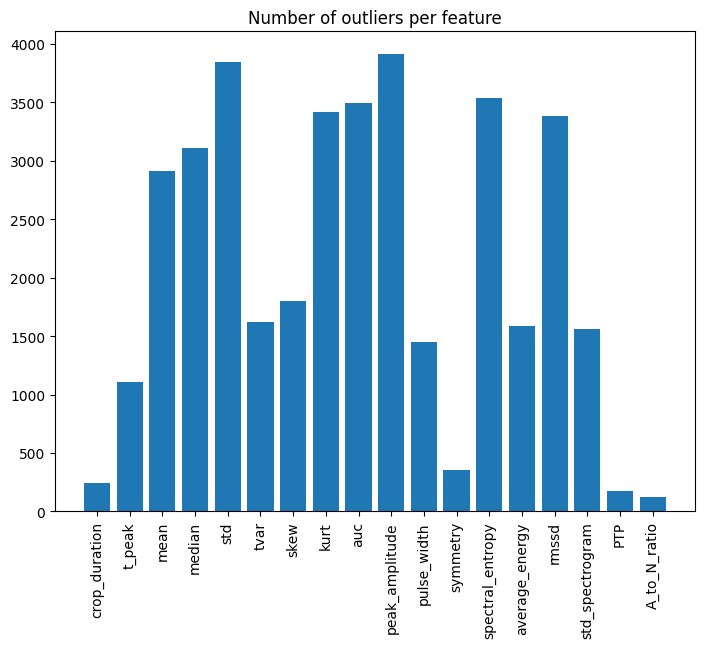

Distribution before subsampling:
148044 4041 5397
26276 711 543
35199 2355 1146

Distribution after subsampling:
labels
N    8082
S    4041
V    4041
Name: count, dtype: int64
labels
N    1086
V     543
S     543
Name: count, dtype: int64
labels
N    35199
V     2355
S     1146
Name: count, dtype: int64
Deleted features: {'rmssd', 'mean', 'peak_amplitude', 'std', 'std_spectrogram', 'tvar', 'average_energy'}


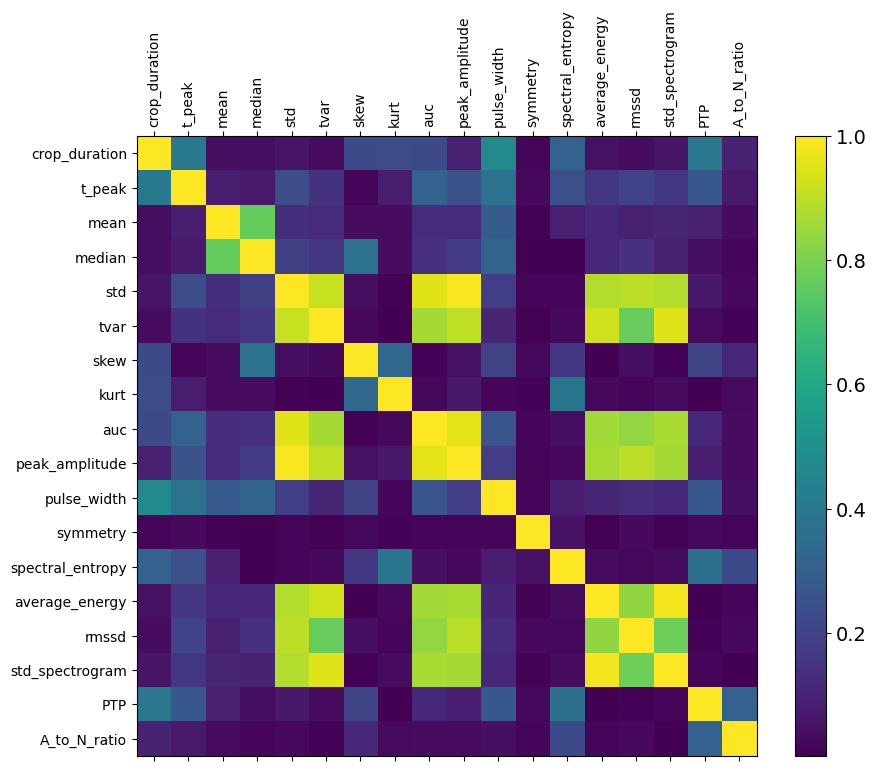

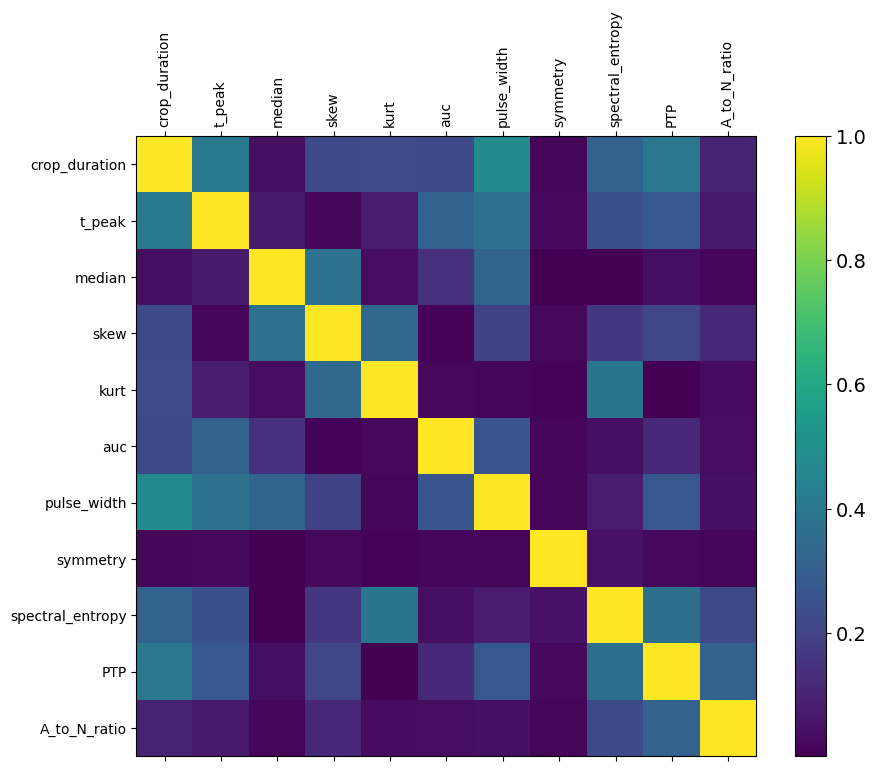

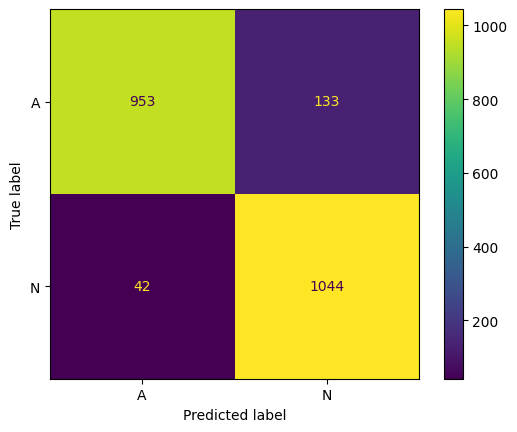

              precision    recall  f1-score   support

           A      0.958     0.878     0.916      1086
           N      0.887     0.961     0.923      1086

    accuracy                          0.919      2172
   macro avg      0.922     0.919     0.919      2172
weighted avg      0.922     0.919     0.919      2172



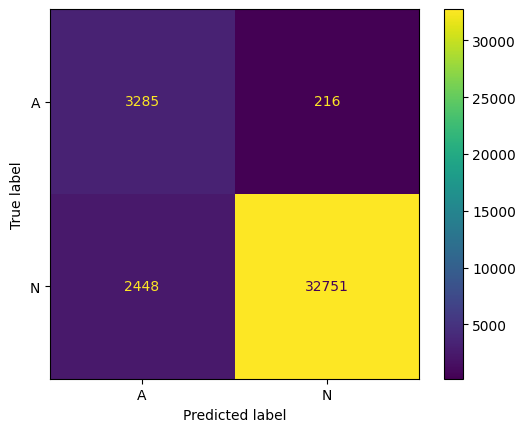

              precision    recall  f1-score   support

           A      0.573     0.938     0.712      3501
           N      0.993     0.930     0.961     35199

    accuracy                          0.931     38700
   macro avg      0.783     0.934     0.836     38700
weighted avg      0.955     0.931     0.938     38700



In [8]:
# Get predictor
# clf = RandomForestClassifier(criterion='gini',
#                              n_estimators=50,
#                              max_depth=None,
#                              min_samples_split=2,
#                              min_samples_leaf=1,
#                              max_features='sqrt',

#                              min_weight_fraction_leaf=0.0,
#                              max_leaf_nodes=None,
#                              min_impurity_decrease=0.0,
#                              bootstrap=True,
#                              oob_score=False,
#                              n_jobs=None,
#                              random_state=36,
#                              verbose=0,
#                              warm_start=False,
#                              class_weight=None,
#                              ccp_alpha=0.0,
#                              max_samples=None)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=36)

# clf = SVC(C=1.0,
#         kernel='rbf', # linear ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
#         degree=6,
#         gamma='scale',
#         coef0=0.0,
#         shrinking=True,
#         probability=True,
#         tol=0.001,
#         cache_size=200,
#         class_weight=None,
#         verbose=False,
#         max_iter=- 1,
#         decision_function_shape='ovr',
#         break_ties=False)

exp = ML_experiment(threshold=0.75, reporting=True)
exp.main(clf)

predictor = exp.clf

In [9]:
test_prediction_prob = exp.get_prob()
# test_labels = exp.test_labels
test_prediction = predictor.predict(exp.test_features_zscore)

# print(test_prediction_prob)

idx_N = np.where(test_prediction == 'N')[0]
idx_A = np.where(test_prediction == 'A')[0]

prob_0 = test_prediction_prob[idx_N, 1]
prob_1 = test_prediction_prob[idx_A, 0]
prob_all = np.concatenate([prob_0, prob_1])

print(prob_all.mean(), prob_0.mean(), prob_1.mean())

# # Histogram predictions without error bars:
# fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# fig.suptitle('Confidence of peaks predictions')

# ax.boxplot([test_prediction_prob[idx_N, 1], test_prediction_prob[idx_A, 0]], labels=['N', 'A'])

# # ax.set_title('Confidence of Abnormal peaks predictions')

# ax.set_ylabel('Confidence of prediction')
# ax.set_xlabel('Class type')
#     # ax.legend()

# plt.show()   

0.9181396089379731 0.9264970854034519 0.8700808392471585


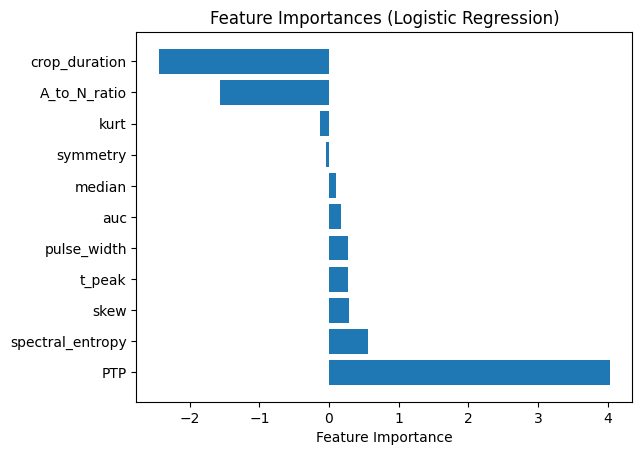

In [153]:
# Assuming you have already trained your logistic regression model (exp.clf)
feature_names = exp.clf.feature_names_in_
importances = exp.clf.coef_[0]  # Taking absolute values for logistic regression

# Sort the features based on their importances
sorted_indices = importances.argsort()[::-1]
sorted_feature_names = feature_names[sorted_indices]
sorted_importances = importances[sorted_indices]

# Create a horizontal bar plot
plt.barh(range(len(sorted_feature_names)), sorted_importances, align="center")
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel("Feature Importance")
plt.title("Feature Importances (Logistic Regression)")
plt.show()

In [154]:
print(exp.clf.feature_names_in_, exp.clf.coef_[0])

['crop_duration' 't_peak' 'median' 'skew' 'kurt' 'auc' 'pulse_width'
 'symmetry' 'spectral_entropy' 'PTP' 'A_to_N_ratio'] [-2.4401269   0.27792829  0.10258138  0.29015824 -0.12982272  0.17700485
  0.27298847 -0.03807032  0.5589147   4.03376398 -1.56859492]


In [155]:
exp.clf

LogisticRegression(random_state=36)

filtering signal S001_128.mat...
filtering signal S013_128.mat...
filtering signal S029_128.mat...
filtering signal S030_128.mat...
filtering signal S035_128.mat...
filtering signal S043_128.mat...
filtering signal S051_128.mat...
filtering signal S053_128.mat...
filtering signal S079_250.mat...
filtering signal S082_250.mat...
filtering signal S088_250.mat...
filtering signal S092_250.mat...
filtering signal S093_250.mat...
filtering signal S095_250.mat...
filtering signal S099_250.mat...
filtering signal S113_250.mat...


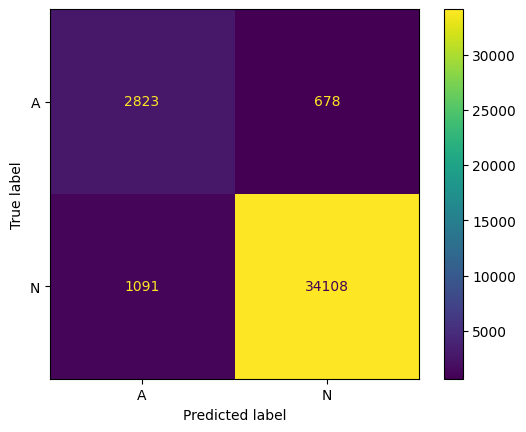

              precision    recall  f1-score   support

           A      0.721     0.806     0.761      3501
           N      0.981     0.969     0.975     35199

    accuracy                          0.954     38700
   macro avg      0.851     0.888     0.868     38700
weighted avg      0.957     0.954     0.955     38700

0.9305581139523135 0.9413794038400279 0.8343830015266528


In [156]:
test_GT = np.array([])
test_pred = np.array([])
probabilities = []



for file_name in files_input:
    recording = ML_Test(file_name, predictor=predictor)

    df = recording.initialize_dataframe()

    features_all = ['crop_duration','t_peak','mean','median','std','tvar','skew','kurt',
                                'auc','peak_amplitude','pulse_width','symmetry', 'spectral_entropy','average_energy',
                                'rmssd', 'std_spectrogram',
                                'PTP','A_to_N_ratio']
    features_keep = ['crop_duration','t_peak','median','skew','kurt','auc','pulse_width','symmetry','spectral_entropy','PTP','A_to_N_ratio']

    features_keep_idx = [i for i, feature in enumerate(features_all) if feature in features_keep]

    for i in range(df.shape[0]):
        row_i = df.drop(["peaks", "labels"], axis=1).loc[i:i]
        row_i_zscore = exp.transformer.transform(row_i)[:,features_keep_idx]
        # print(exp.clf.predict(row_i_zscore)[0])

        df.loc[i,'labels'] = exp.clf.predict(row_i_zscore)[0]
        df.loc[i+1,'A_to_N_ratio'] = A_to_N_ratio(df.loc[i:i])[0]

        prob = exp.clf.predict_proba(row_i_zscore)

        # print(prob)

        probabilities.extend(prob)

    test_GT_crop = recording.labels.copy()
    test_GT_crop[test_GT_crop == 'V'] = 'A'
    test_GT_crop[test_GT_crop == 'S'] = 'A'

    test_GT = np.concatenate([test_GT, test_GT_crop])
    test_pred = np.concatenate([test_pred, np.array(df.iloc[:-1].labels)])

probabilities = np.array(probabilities)

plot_confusionMatrix(test_GT, test_pred, exp.clf)
print(classification_report(test_GT, test_pred, target_names=clf.classes_, digits=3))

idx_N = np.where(test_pred == 'N')[0]
idx_A = np.where((test_pred == 'V')+(test_pred == 'S')+(test_pred == 'A'))[0]

prob_0 = probabilities[idx_N, 1]
prob_1 = probabilities[idx_A, 0]
prob_all = np.concatenate([prob_0, prob_1])

print(prob_all.mean(), prob_0.mean(), prob_1.mean())

In [103]:
def A_to_N_ratio(self, time_window=20, fs=128):
    indices_before = int(time_window*fs)

    ratio = np.zeros(len(self.peaks))
    for i, peak_idx in enumerate(self.peaks):
        indices_in_window = np.where((peak_idx - indices_before <= self.peaks) & (self.peaks < peak_idx))[0]

        count_N = np.count_nonzero((self.labels[indices_in_window] ==  'N'))
        count_V = np.count_nonzero((self.labels[indices_in_window] ==  'V'))
        count_S = np.count_nonzero((self.labels[indices_in_window] ==  'S'))
        count_A = np.count_nonzero((self.labels[indices_in_window] ==  'A'))
        
        # Handle the case were count_N is 0
        if count_N == 0:
            count_N = 1

        ratio[i] = (count_V+count_S+count_A)/count_N

    return ratio

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusionMatrix(test_labels, test_predicted, clf):
        cm = confusion_matrix(test_labels, test_predicted, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                        display_labels=clf.classes_)
        disp.plot()
        plt.show()
        return

filtering signal S001_128.mat...
filtering signal S013_128.mat...
filtering signal S029_128.mat...
filtering signal S030_128.mat...
filtering signal S035_128.mat...
filtering signal S043_128.mat...
filtering signal S051_128.mat...
filtering signal S053_128.mat...
filtering signal S079_250.mat...
filtering signal S082_250.mat...
filtering signal S088_250.mat...
filtering signal S092_250.mat...
filtering signal S093_250.mat...
filtering signal S095_250.mat...
filtering signal S099_250.mat...
filtering signal S113_250.mat...


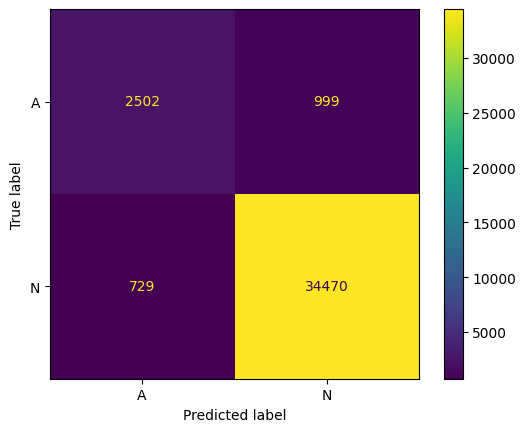

              precision    recall  f1-score   support

           A      0.774     0.715     0.743      3501
           N      0.972     0.979     0.976     35199

    accuracy                          0.955     38700
   macro avg      0.873     0.847     0.859     38700
weighted avg      0.954     0.955     0.955     38700

0.9228961240310078 0.9362265640418395 0.7765583410708758


In [104]:
test_GT = np.array([])
test_pred = np.array([])
probabilities = []



for file_name in files_input:
    recording = ML_Test(file_name, predictor=predictor)

    df = recording.initialize_dataframe()

    features_all = ['crop_duration','t_peak','mean','median','std','tvar','skew','kurt',
                                'auc','peak_amplitude','pulse_width','symmetry', 'spectral_entropy','average_energy',
                                'rmssd', 'std_spectrogram',
                                'PTP','A_to_N_ratio']
    features_keep = ['crop_duration','t_peak','median','skew','kurt','auc','pulse_width','symmetry','spectral_entropy','PTP','A_to_N_ratio']

    features_keep_idx = [i for i, feature in enumerate(features_all) if feature in features_keep]

    for i in range(df.shape[0]):
        row_i = df.drop(["peaks", "labels"], axis=1).loc[i:i]
        row_i_zscore = exp.transformer.transform(row_i)[:,features_keep_idx]
        # print(exp.clf.predict(row_i_zscore)[0])

        df.loc[i,'labels'] = exp.clf.predict(row_i_zscore)[0]
        df.loc[i+1,'A_to_N_ratio'] = A_to_N_ratio(df.loc[i:i])[0]

        prob = exp.clf.predict_proba(row_i_zscore)

        # print(prob)

        probabilities.extend(prob)

    test_GT_crop = recording.labels.copy()
    test_GT_crop[test_GT_crop == 'V'] = 'A'
    test_GT_crop[test_GT_crop == 'S'] = 'A'

    test_GT = np.concatenate([test_GT, test_GT_crop])
    test_pred = np.concatenate([test_pred, np.array(df.iloc[:-1].labels)])

probabilities = np.array(probabilities)

plot_confusionMatrix(test_GT, test_pred, exp.clf)
print(classification_report(test_GT, test_pred, target_names=clf.classes_, digits=3))

idx_N = np.where(test_pred == 'N')[0]
idx_A = np.where((test_pred == 'V')+(test_pred == 'S')+(test_pred == 'A'))[0]

prob_0 = probabilities[idx_N, 1]
prob_1 = probabilities[idx_A, 0]
prob_all = np.concatenate([prob_0, prob_1])

print(prob_all.mean(), prob_0.mean(), prob_1.mean())

In [98]:
probabilities.shape

(38700, 2)

TypeError: list indices must be integers or slices, not tuple

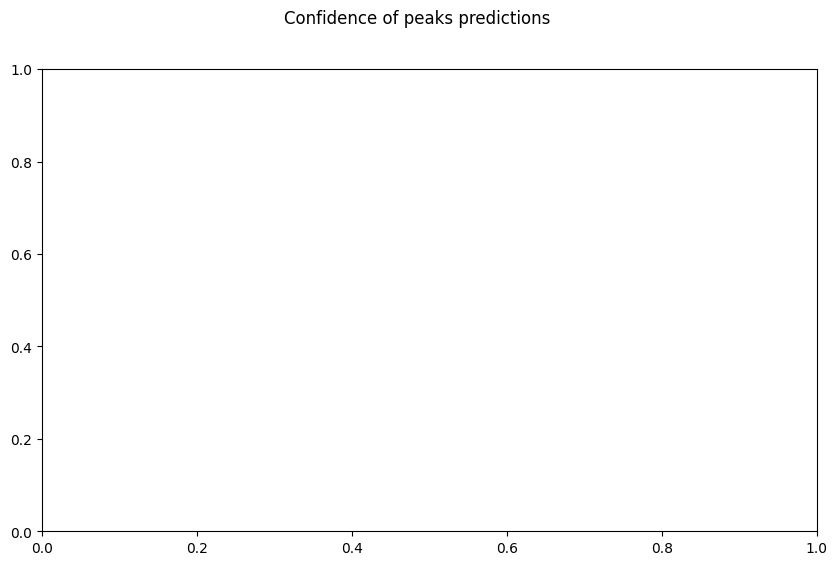

In [135]:
# print(test_prediction_prob)

idx_N = np.where(test_pred == 'N')[0]
idx_A = np.where((test_pred == 'V')+(test_pred == 'S')+(test_pred == 'A'))[0]

# Histogram predictions without error bars:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

fig.suptitle('Confidence of peaks predictions')

ax.boxplot([probabilities[idx_N, 1], probabilities[idx_A, 0]], labels=['N', 'A'])

# ax.set_title('Confidence of Abnormal peaks predictions')

ax.set_ylabel('Confidence of prediction')
ax.set_xlabel('Class type')
    # ax.legend()

plt.show() 

Training set size:	72
[54, 17, 96, 119, 103, 57, 24, 8, 89, 80, 39, 16, 121, 48, 106, 44, 11, 49, 117, 91, 98, 33, 9, 114, 90, 110, 104, 85, 5, 27, 52, 18, 58, 50, 86, 101, 21, 19, 20, 109, 42, 25, 84, 26, 47, 102, 112, 14, 22, 46, 118, 94, 15, 37, 105, 2, 32, 23, 115, 87, 81, 7, 56, 38, 10, 45, 108, 34, 41, 31, 116, 6]
Validation set size:	15
[36, 97, 60, 28, 40, 100, 3, 83, 111, 62, 12, 61, 59, 4, 55]
Test set size:		16
[53, 51, 79, 1, 29, 30, 93, 82, 35, 43, 92, 99, 95, 88, 113, 13]
Missing values before outlier removal: 0
Outliers detected (train): 37618
Missing values after outlier removal (train): 37618
Outliers detected (validation): 11026
Missing values after outlier removal (validation): 11026
Distribution before subsampling:
148044 4041 5397
26276 711 543
35199 2355 1146

Distribution after subsampling:
labels
N    8082
S    4041
V    4041
Name: count, dtype: int64
labels
N    1086
V     543
S     543
Name: count, dtype: int64
labels
N    35199
V     2355
S     1146
Name: cou

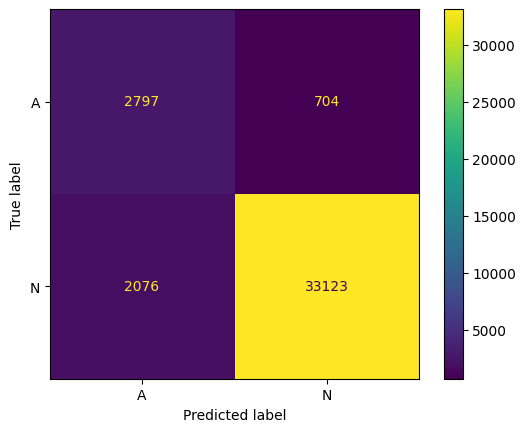

              precision    recall  f1-score   support

           A      0.574     0.799     0.668      3501
           N      0.979     0.941     0.960     35199

    accuracy                          0.928     38700
   macro avg      0.777     0.870     0.814     38700
weighted avg      0.943     0.928     0.933     38700

0.8956816537467701 0.9418340378987201 0.5753047404063205


In [113]:
clf = SVC(C=1.0,
        kernel='rbf', # linear ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
        degree=4,
        gamma='scale',
        coef0=0.0,
        shrinking=True,
        probability=True,
        tol=0.001,
        cache_size=200,
        class_weight=None,
        verbose=False,
        max_iter=- 1,
        decision_function_shape='ovr',
        break_ties=False)

exp = ML_experiment(threshold=0.75, reporting=False)
exp.main(clf)

predictor = exp.clf

test_GT_SVM = np.array([])
test_pred_SVM = np.array([])
probabilities_SVM = []



for file_name in files_input:
    recording = ML_Test(file_name, predictor=predictor)

    df = recording.initialize_dataframe()

    features_all = ['crop_duration','t_peak','mean','median','std','tvar','skew','kurt',
                                'auc','peak_amplitude','pulse_width','symmetry', 'spectral_entropy','average_energy',
                                'rmssd', 'std_spectrogram',
                                'PTP','A_to_N_ratio']
    features_keep = ['crop_duration','t_peak','median','skew','kurt','auc','pulse_width','symmetry','spectral_entropy','PTP','A_to_N_ratio']

    features_keep_idx = [i for i, feature in enumerate(features_all) if feature in features_keep]

    for i in range(df.shape[0]):
        row_i = df.drop(["peaks", "labels"], axis=1).loc[i:i]
        row_i_zscore = exp.transformer.transform(row_i)[:,features_keep_idx]
        # print(exp.clf.predict(row_i_zscore)[0])

        df.loc[i,'labels'] = exp.clf.predict(row_i_zscore)[0]
        df.loc[i+1,'A_to_N_ratio'] = A_to_N_ratio(df.loc[i:i])[0]

        prob = exp.clf.predict_proba(row_i_zscore)

        # print(prob)

        probabilities_SVM.extend(prob)

    test_GT_crop = recording.labels.copy()
    test_GT_crop[test_GT_crop == 'V'] = 'A'
    test_GT_crop[test_GT_crop == 'S'] = 'A'

    test_GT_SVM = np.concatenate([test_GT_SVM, test_GT_crop])
    test_pred_SVM = np.concatenate([test_pred_SVM, np.array(df.iloc[:-1].labels)])

probabilities_SVM = np.array(probabilities)

plot_confusionMatrix(test_GT_SVM, test_pred_SVM, exp.clf)
print(classification_report(test_GT_SVM, test_pred_SVM, target_names=clf.classes_, digits=3))

idx_N_SVM = np.where(test_pred_SVM == 'N')[0]
idx_A_SVM = np.where((test_pred_SVM == 'V')+(test_pred_SVM == 'S')+(test_pred_SVM == 'A'))[0]

prob_0_SVM = probabilities_SVM[idx_N_SVM, 1]
prob_1_SVM = probabilities_SVM[idx_A_SVM, 0]
prob_all_SVM = np.concatenate([prob_0_SVM, prob_1_SVM])

print(prob_all_SVM.mean(), prob_0_SVM.mean(), prob_1_SVM.mean())


In [86]:
# idx_N_SVM = np.where(test_pred_SVM == 'N')[0]
# idx_A_SVM = np.where((test_pred_SVM == 'V')+(test_pred_SVM == 'S')+(test_pred_SVM == 'A'))[0]

# prob_0_SVM = probabilities_SVM[idx_N_SVM, 1]
# prob_1_SVM = probabilities_SVM[idx_A_SVM, 0]
# prob_all_SVM = np.concatenate([prob_0_SVM, prob_1_SVM])

# print(prob_all_SVM.mean(), prob_0_SVM.mean(), prob_1_SVM.mean())

test_GT_SVM.shape

(41285,)

In [83]:
probabilities_SVM.shape, idx_N_SVM

((38700, 2),
 array([    0,     1,     2, ..., 41282, 41283, 41284], dtype=int64))

In [ ]:
clf = SVC(C=1.0,
        kernel='sigmoid', # linear ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
        degree=5,
        gamma='scale',
        coef0=0.0,
        shrinking=True,
        probability=True,
        tol=0.001,
        cache_size=200,
        class_weight=None,
        verbose=False,
        max_iter=- 1,
        decision_function_shape='ovr',
        break_ties=False)

exp = ML_experiment(threshold=0.75, reporting=False)
exp.main(clf)

predictor = exp.clf

test_GT_SVM = np.array([])
test_pred_SVM = np.array([])
probabilities_SVM = []



for file_name in files_input:
    recording = ML_Test(file_name, predictor=predictor)

    df = recording.initialize_dataframe()

    features_all = ['crop_duration','t_peak','mean','median','std','tvar','skew','kurt',
                                'auc','peak_amplitude','pulse_width','symmetry', 'spectral_entropy','average_energy',
                                'rmssd', 'std_spectrogram',
                                'PTP','A_to_N_ratio']
    features_keep = ['crop_duration','t_peak','median','skew','kurt','auc','pulse_width','symmetry','spectral_entropy','PTP','A_to_N_ratio']

    features_keep_idx = [i for i, feature in enumerate(features_all) if feature in features_keep]

    for i in range(df.shape[0]):
        row_i = df.drop(["peaks", "labels"], axis=1).loc[i:i]
        row_i_zscore = exp.transformer.transform(row_i)[:,features_keep_idx]
        # print(exp.clf.predict(row_i_zscore)[0])

        df.loc[i,'labels'] = exp.clf.predict(row_i_zscore)[0]
        df.loc[i+1,'A_to_N_ratio'] = A_to_N_ratio(df.loc[i:i])[0]

        prob = exp.clf.predict_proba(row_i_zscore)

        # print(prob)

        probabilities_SVM.extend(prob)

    test_GT_crop = recording.labels.copy()
    test_GT_crop[test_GT_crop == 'V'] = 'A'
    test_GT_crop[test_GT_crop == 'S'] = 'A'

    test_GT_SVM = np.concatenate([test_GT_SVM, test_GT_crop])
    test_pred_SVM = np.concatenate([test_pred_SVM, np.array(df.iloc[:-1].labels)])

probabilities_SVM = np.array(probabilities)

plot_confusionMatrix(test_GT_SVM, test_pred_SVM, exp.clf)
print(classification_report(test_GT_SVM, test_pred_SVM, target_names=clf.classes_, digits=3))

idx_N_SVM = np.where(test_pred_SVM == 'N')[0]
idx_A_SVM = np.where((test_pred_SVM == 'V')+(test_pred_SVM == 'S')+(test_pred_SVM == 'A'))[0]

prob_0_SVM = probabilities_SVM[idx_N_SVM, 1]
prob_1_SVM = probabilities_SVM[idx_A_SVM, 0]
prob_all_SVM = np.concatenate([prob_0_SVM, prob_1_SVM])

print(prob_all_SVM.mean(), prob_0_SVM.mean(), prob_1_SVM.mean())


In [109]:
idx_N.shape, idx_A.shape

((35469,), (3231,))

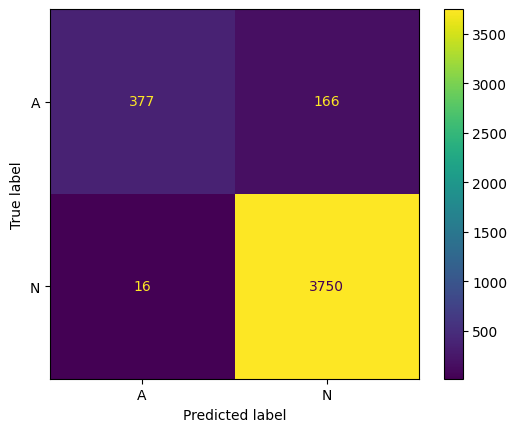

In [29]:
plot_confusionMatrix(test_GT, test_pred, exp.clf)

In [31]:
# np.concatenate([test_GT, np.array([])])
test_GT.shape

(38700,)

In [34]:
print(classification_report(test_GT, test_pred, target_names=clf.classes_))

              precision    recall  f1-score   support

           A       0.77      0.71      0.74      3501
           N       0.97      0.98      0.98     35199

    accuracy                           0.96     38700
   macro avg       0.87      0.85      0.86     38700
weighted avg       0.95      0.96      0.95     38700



## Multiclass

### Logistic Regression

Training set size:	72
[54, 17, 96, 119, 103, 57, 24, 8, 89, 80, 39, 16, 121, 48, 106, 44, 11, 49, 117, 91, 98, 33, 9, 114, 90, 110, 104, 85, 5, 27, 52, 18, 58, 50, 86, 101, 21, 19, 20, 109, 42, 25, 84, 26, 47, 102, 112, 14, 22, 46, 118, 94, 15, 37, 105, 2, 32, 23, 115, 87, 81, 7, 56, 38, 10, 45, 108, 34, 41, 31, 116, 6]
Validation set size:	15
[36, 97, 60, 28, 40, 100, 3, 83, 111, 62, 12, 61, 59, 4, 55]
Test set size:		16
[53, 51, 79, 1, 29, 30, 93, 82, 35, 43, 92, 99, 95, 88, 113, 13]
Missing values before outlier removal: 0
Outliers detected (train): 37618
Missing values after outlier removal (train): 37618
Outliers detected (validation): 11026
Missing values after outlier removal (validation): 11026


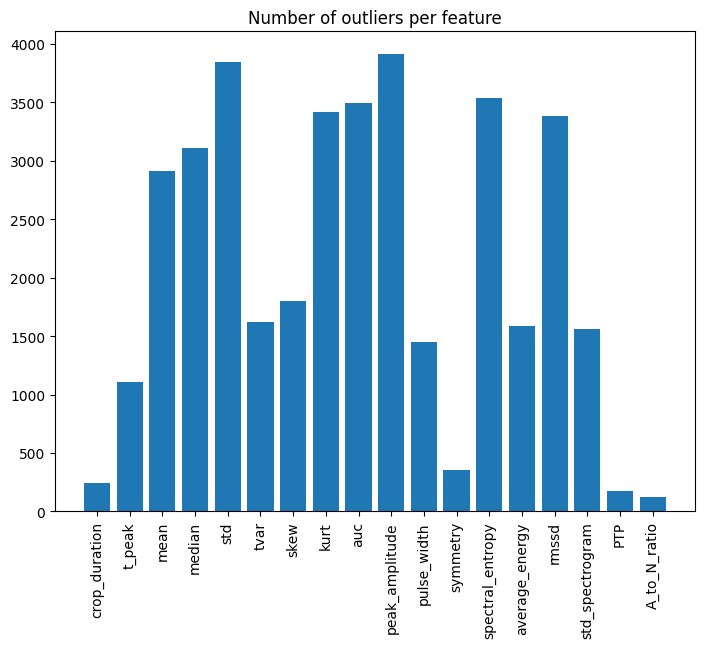

Distribution before subsampling:
148044 4041 5397
26276 711 543
35199 2355 1146

Distribution after subsampling:
labels
S    4041
V    4041
N    4041
Name: count, dtype: int64
labels
V    543
N    543
S    543
Name: count, dtype: int64
labels
N    35199
V     2355
S     1146
Name: count, dtype: int64
Deleted features: {'std_spectrogram', 'tvar', 'peak_amplitude', 'average_energy', 'rmssd', 'mean', 'std'}


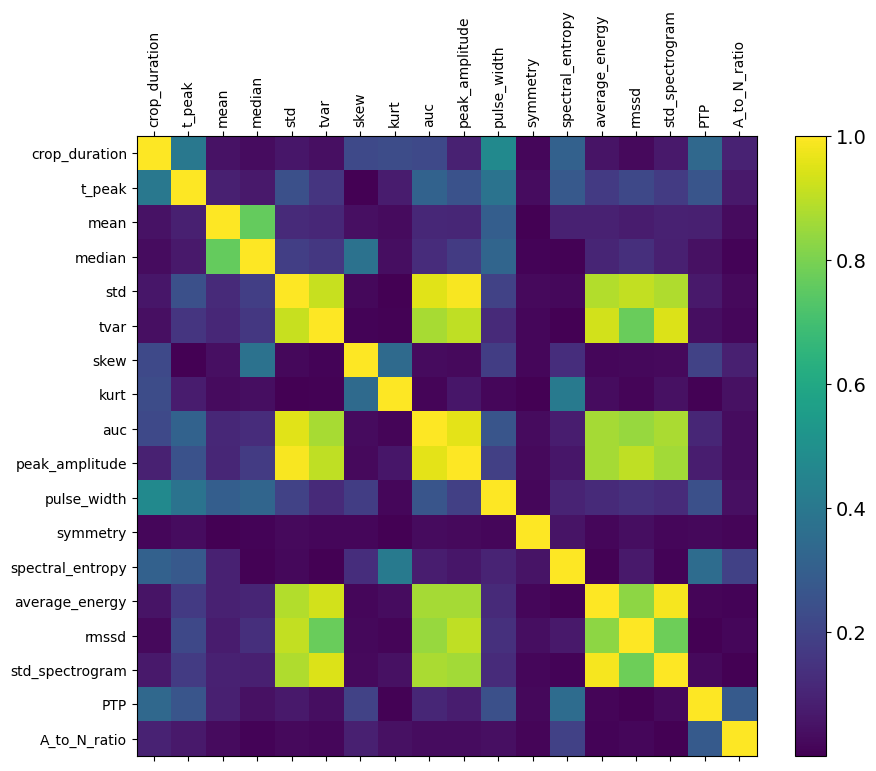

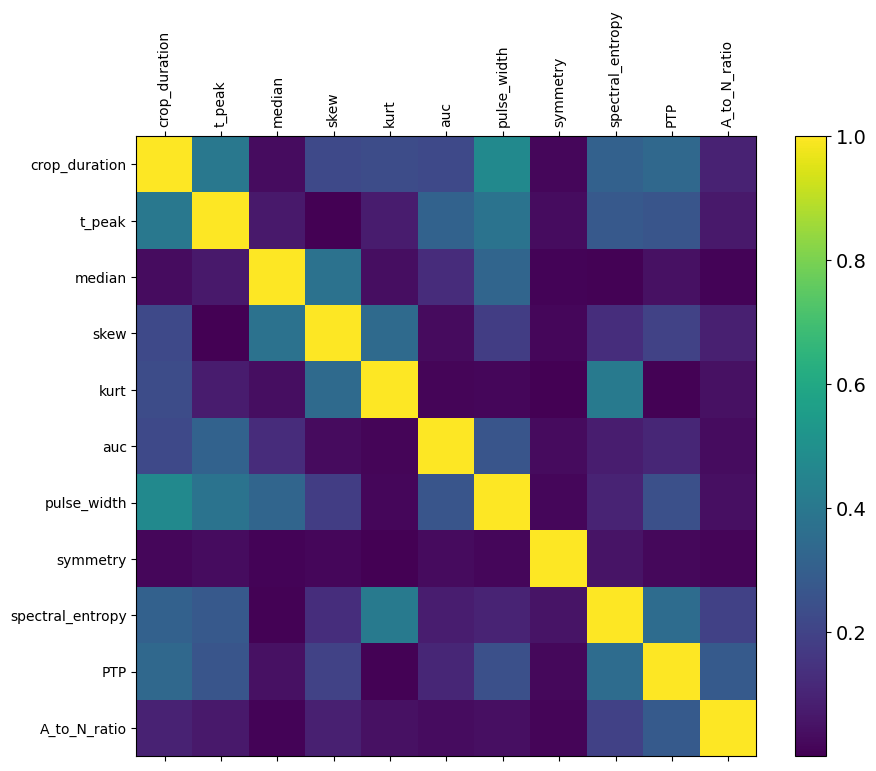

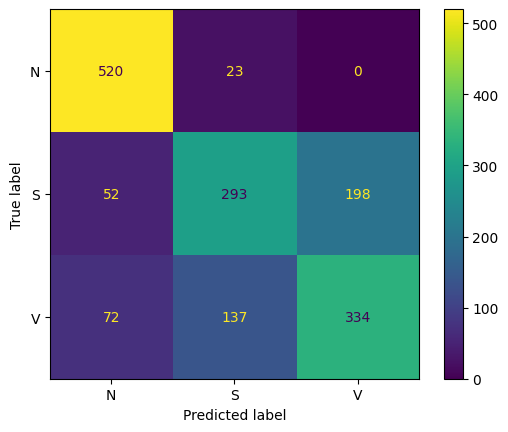

              precision    recall  f1-score   support

           N       0.81      0.96      0.88       543
           S       0.65      0.54      0.59       543
           V       0.63      0.62      0.62       543

    accuracy                           0.70      1629
   macro avg       0.69      0.70      0.70      1629
weighted avg       0.69      0.70      0.70      1629



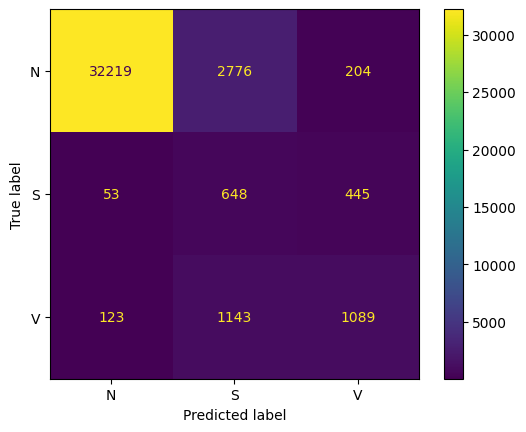

              precision    recall  f1-score   support

           N       0.99      0.92      0.95     35199
           S       0.14      0.57      0.23      1146
           V       0.63      0.46      0.53      2355

    accuracy                           0.88     38700
   macro avg       0.59      0.65      0.57     38700
weighted avg       0.95      0.88      0.91     38700



In [136]:
# Get predictor
# clf = RandomForestClassifier(criterion='gini',
#                              n_estimators=50,
#                              max_depth=None,
#                              min_samples_split=2,
#                              min_samples_leaf=1,
#                              max_features='sqrt',

#                              min_weight_fraction_leaf=0.0,
#                              max_leaf_nodes=None,
#                              min_impurity_decrease=0.0,
#                              bootstrap=True,
#                              oob_score=False,
#                              n_jobs=None,
#                              random_state=36,
#                              verbose=0,
#                              warm_start=False,
#                              class_weight=None,
#                              ccp_alpha=0.0,
#                              max_samples=None)

# from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=36)

# clf = SVC(C=1.0,
#         kernel='rbf', # linear ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
#         degree=6,
#         gamma='scale',
#         coef0=0.0,
#         shrinking=True,
#         probability=True,
#         tol=0.001,
#         cache_size=200,
#         class_weight=None,
#         verbose=False,
#         max_iter=- 1,
#         decision_function_shape='ovr',
#         break_ties=False)

exp = ML_experiment(threshold=0.75, reporting=True, mode='multiclass')
exp.main(clf)

predictor = exp.clf

filtering signal S001_128.mat...
filtering signal S013_128.mat...
filtering signal S029_128.mat...
filtering signal S030_128.mat...
filtering signal S035_128.mat...
filtering signal S043_128.mat...
filtering signal S051_128.mat...
filtering signal S053_128.mat...
filtering signal S079_250.mat...
filtering signal S082_250.mat...
filtering signal S088_250.mat...
filtering signal S092_250.mat...
filtering signal S093_250.mat...
filtering signal S095_250.mat...
filtering signal S099_250.mat...
filtering signal S113_250.mat...


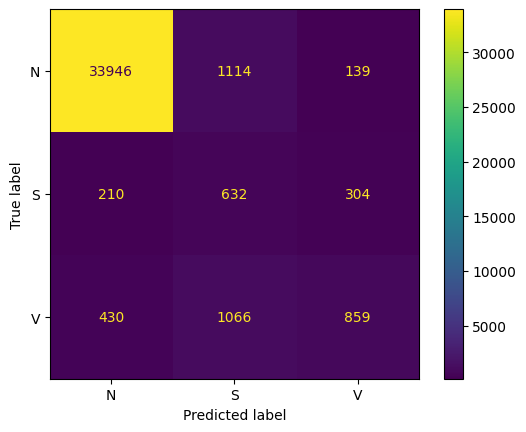

              precision    recall  f1-score   support

           N      0.981     0.964     0.973     35199
           S      0.225     0.551     0.319      1146
           V      0.660     0.365     0.470      2355

    accuracy                          0.916     38700
   macro avg      0.622     0.627     0.587     38700
weighted avg      0.940     0.916     0.923     38700

0.8636648742726346 0.9049141851872552 0.4987900357230918 0.5559685445554691


In [140]:
test_GT = np.array([])
test_pred = np.array([])
probabilities = []

for file_name in files_input:
    recording = ML_Test(file_name, predictor=predictor)

    df = recording.initialize_dataframe()

    features_all = ['crop_duration','t_peak','mean','median','std','tvar','skew','kurt',
                                'auc','peak_amplitude','pulse_width','symmetry', 'spectral_entropy','average_energy',
                                'rmssd', 'std_spectrogram',
                                'PTP','A_to_N_ratio']
    features_keep = ['crop_duration','t_peak','median','skew','kurt','auc','pulse_width','symmetry','spectral_entropy','PTP','A_to_N_ratio']

    features_keep_idx = [i for i, feature in enumerate(features_all) if feature in features_keep]

    for i in range(df.shape[0]):
        row_i = df.drop(["peaks", "labels"], axis=1).loc[i:i]
        row_i_zscore = exp.transformer.transform(row_i)[:,features_keep_idx]
        # print(exp.clf.predict(row_i_zscore)[0])

        df.loc[i,'labels'] = exp.clf.predict(row_i_zscore)[0]
        df.loc[i+1,'A_to_N_ratio'] = A_to_N_ratio(df.loc[i:i])[0]

        prob = exp.clf.predict_proba(row_i_zscore)

        # print(prob)

        probabilities.extend(prob)

    test_GT_crop = recording.labels.copy()
    # test_GT_crop[test_GT_crop == 'V'] = 'A'
    # test_GT_crop[test_GT_crop == 'S'] = 'A'

    test_GT = np.concatenate([test_GT, test_GT_crop])
    test_pred = np.concatenate([test_pred, np.array(df.iloc[:-1].labels)])

probabilities = np.array(probabilities)

plot_confusionMatrix(test_GT, test_pred, exp.clf)
print(classification_report(test_GT, test_pred, target_names=clf.classes_, digits=3))

idx_N = np.where(test_pred == 'N')[0]
idx_S = np.where(test_pred == 'S')[0]
idx_V = np.where(test_pred == 'V')[0]

prob_N = probabilities[idx_N, 0]
prob_S = probabilities[idx_S, 1]
prob_V = probabilities[idx_V, 2]
prob_all = np.concatenate([prob_N, prob_S, prob_V])

print(prob_all.mean(), prob_N.mean(), prob_S.mean(), prob_V.mean())

Training set size:	72
[54, 17, 96, 119, 103, 57, 24, 8, 89, 80, 39, 16, 121, 48, 106, 44, 11, 49, 117, 91, 98, 33, 9, 114, 90, 110, 104, 85, 5, 27, 52, 18, 58, 50, 86, 101, 21, 19, 20, 109, 42, 25, 84, 26, 47, 102, 112, 14, 22, 46, 118, 94, 15, 37, 105, 2, 32, 23, 115, 87, 81, 7, 56, 38, 10, 45, 108, 34, 41, 31, 116, 6]
Validation set size:	15
[36, 97, 60, 28, 40, 100, 3, 83, 111, 62, 12, 61, 59, 4, 55]
Test set size:		16
[53, 51, 79, 1, 29, 30, 93, 82, 35, 43, 92, 99, 95, 88, 113, 13]
Missing values before outlier removal: 0
Outliers detected (train): 37618
Missing values after outlier removal (train): 37618
Outliers detected (validation): 11026
Missing values after outlier removal (validation): 11026


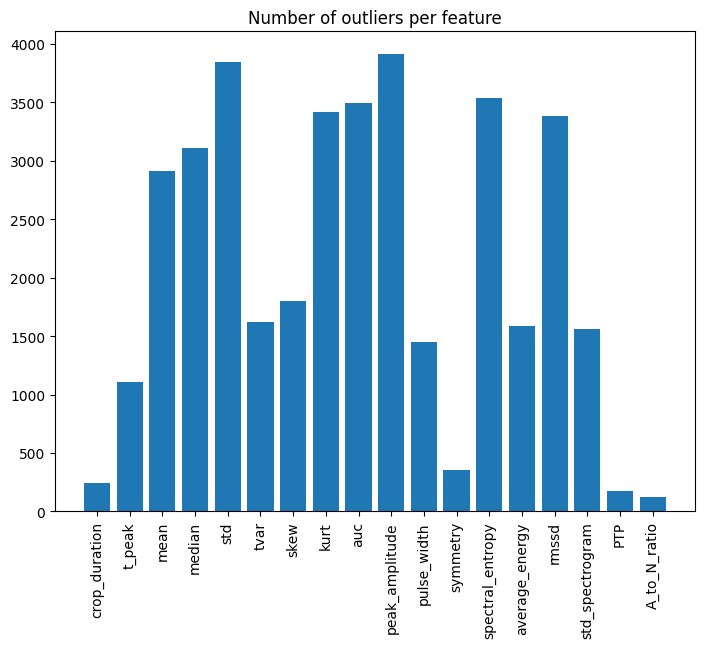

Distribution before subsampling:
148044 4041 5397
26276 711 543
35199 2355 1146

Distribution after subsampling:
labels
S    4041
V    4041
N    4041
Name: count, dtype: int64
labels
V    543
N    543
S    543
Name: count, dtype: int64
labels
N    35199
V     2355
S     1146
Name: count, dtype: int64
Deleted features: {'std_spectrogram', 'tvar', 'peak_amplitude', 'average_energy', 'rmssd', 'mean', 'std'}


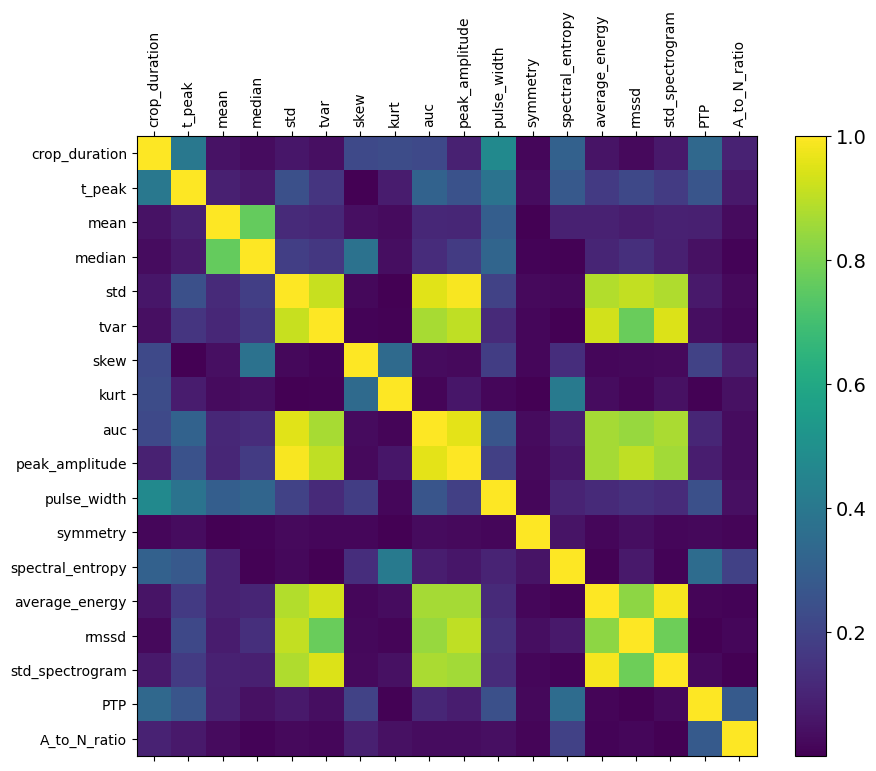

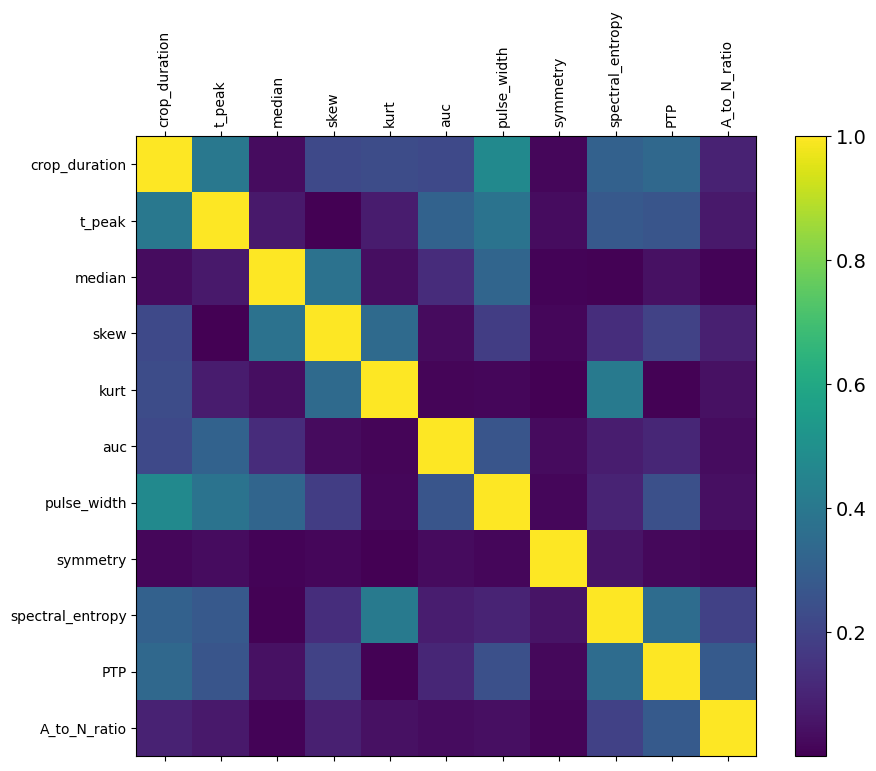

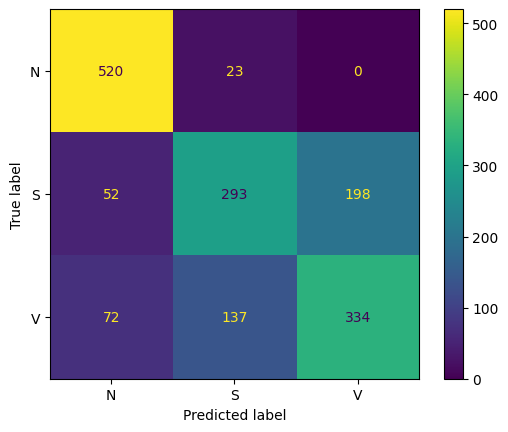

              precision    recall  f1-score   support

           N       0.81      0.96      0.88       543
           S       0.65      0.54      0.59       543
           V       0.63      0.62      0.62       543

    accuracy                           0.70      1629
   macro avg       0.69      0.70      0.70      1629
weighted avg       0.69      0.70      0.70      1629



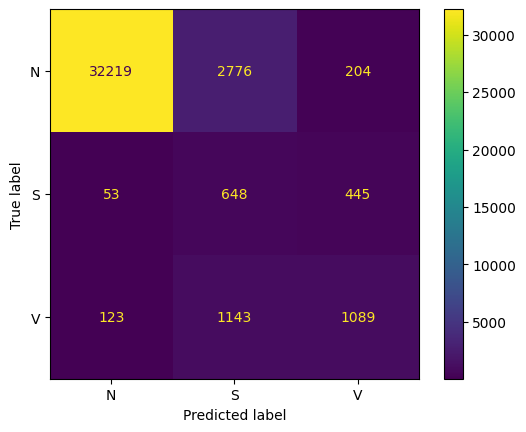

              precision    recall  f1-score   support

           N       0.99      0.92      0.95     35199
           S       0.14      0.57      0.23      1146
           V       0.63      0.46      0.53      2355

    accuracy                           0.88     38700
   macro avg       0.59      0.65      0.57     38700
weighted avg       0.95      0.88      0.91     38700



In [143]:
clf = LogisticRegression(random_state=36)

exp = ML_experiment(threshold=0.75, reporting=True, mode='multiclass')
exp.main(clf)

predictor = exp.clf

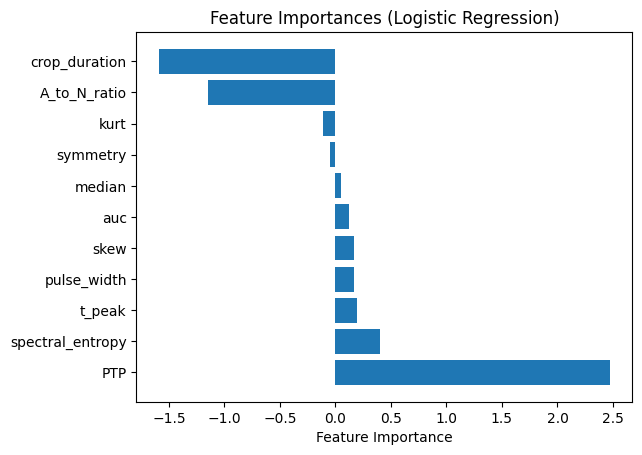

In [145]:
# Assuming you have already trained your logistic regression model (exp.clf)
feature_names = exp.clf.feature_names_in_
importances = exp.clf.coef_[0]  # Taking absolute values for logistic regression

# Sort the features based on their importances
sorted_indices = importances.argsort()[::-1]
sorted_feature_names = feature_names[sorted_indices]
sorted_importances = importances[sorted_indices]

# Create a horizontal bar plot
plt.barh(range(len(sorted_feature_names)), sorted_importances, align="center")
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel("Feature Importance")
plt.title("Feature Importances (Logistic Regression)")
plt.show()

### Random Forest

Training set size:	72
[54, 17, 96, 119, 103, 57, 24, 8, 89, 80, 39, 16, 121, 48, 106, 44, 11, 49, 117, 91, 98, 33, 9, 114, 90, 110, 104, 85, 5, 27, 52, 18, 58, 50, 86, 101, 21, 19, 20, 109, 42, 25, 84, 26, 47, 102, 112, 14, 22, 46, 118, 94, 15, 37, 105, 2, 32, 23, 115, 87, 81, 7, 56, 38, 10, 45, 108, 34, 41, 31, 116, 6]
Validation set size:	15
[36, 97, 60, 28, 40, 100, 3, 83, 111, 62, 12, 61, 59, 4, 55]
Test set size:		16
[53, 51, 79, 1, 29, 30, 93, 82, 35, 43, 92, 99, 95, 88, 113, 13]
Missing values before outlier removal: 0
Outliers detected (train): 37618
Missing values after outlier removal (train): 37618
Outliers detected (validation): 11026
Missing values after outlier removal (validation): 11026


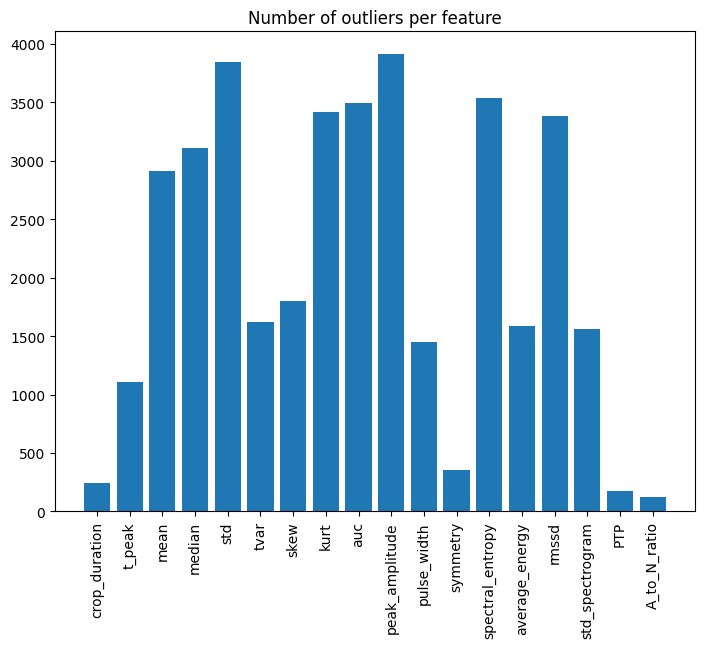

Distribution before subsampling:
148044 4041 5397
26276 711 543
35199 2355 1146

Distribution after subsampling:
labels
S    4041
V    4041
N    4041
Name: count, dtype: int64
labels
V    543
N    543
S    543
Name: count, dtype: int64
labels
N    35199
V     2355
S     1146
Name: count, dtype: int64
Deleted features: {'std_spectrogram', 'tvar', 'peak_amplitude', 'average_energy', 'rmssd', 'mean', 'std'}


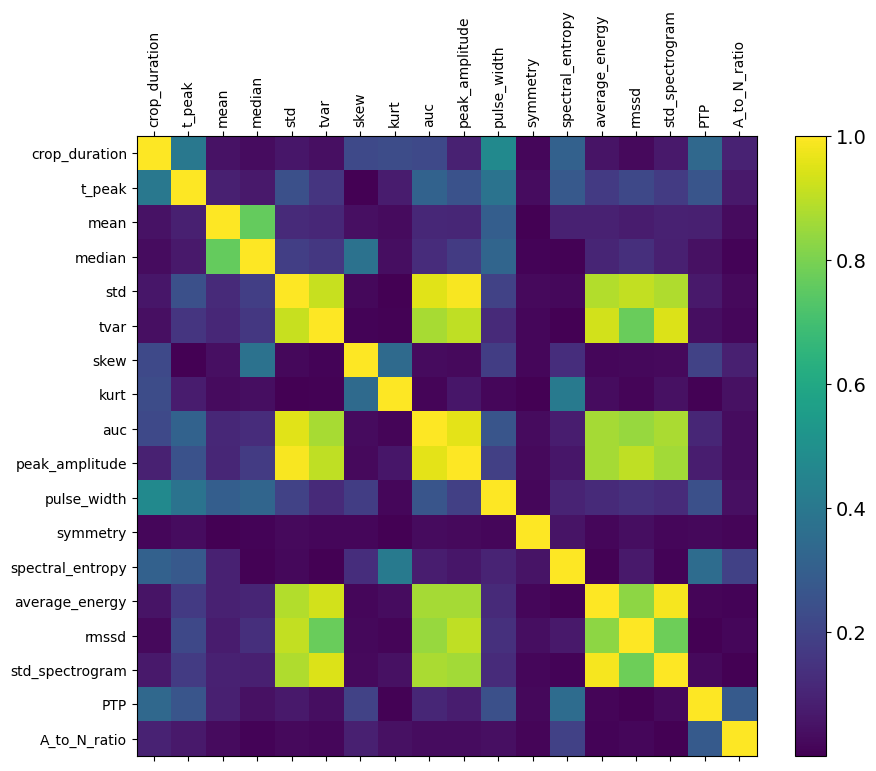

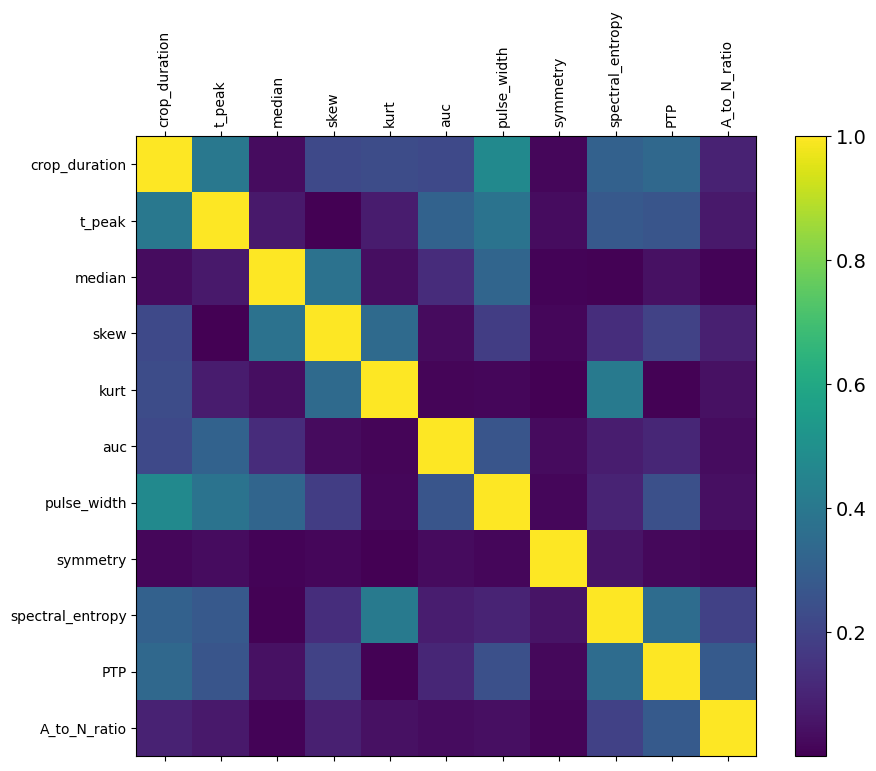

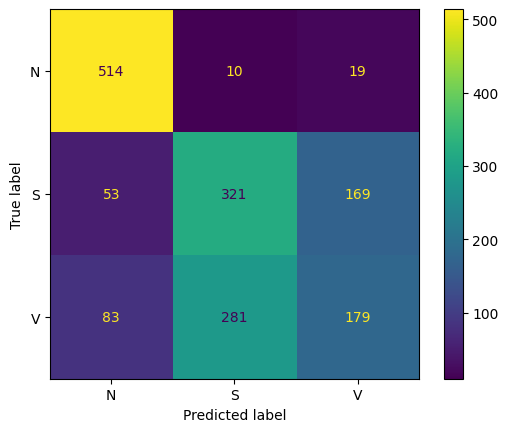

              precision    recall  f1-score   support

           N       0.79      0.95      0.86       543
           S       0.52      0.59      0.56       543
           V       0.49      0.33      0.39       543

    accuracy                           0.62      1629
   macro avg       0.60      0.62      0.60      1629
weighted avg       0.60      0.62      0.60      1629



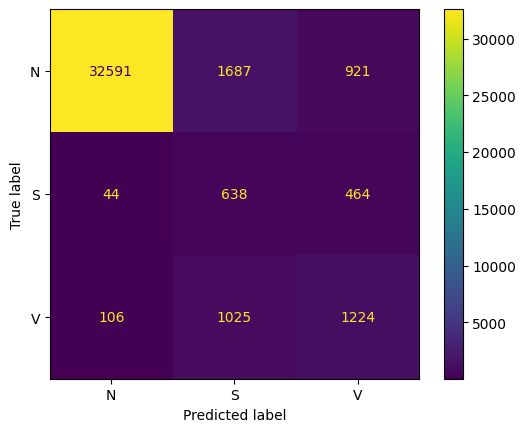

              precision    recall  f1-score   support

           N       1.00      0.93      0.96     35199
           S       0.19      0.56      0.28      1146
           V       0.47      0.52      0.49      2355

    accuracy                           0.89     38700
   macro avg       0.55      0.67      0.58     38700
weighted avg       0.94      0.89      0.91     38700

filtering signal S001_128.mat...
filtering signal S013_128.mat...
filtering signal S029_128.mat...
filtering signal S030_128.mat...
filtering signal S035_128.mat...
filtering signal S043_128.mat...
filtering signal S051_128.mat...
filtering signal S053_128.mat...
filtering signal S079_250.mat...
filtering signal S082_250.mat...
filtering signal S088_250.mat...
filtering signal S092_250.mat...
filtering signal S093_250.mat...
filtering signal S095_250.mat...
filtering signal S099_250.mat...
filtering signal S113_250.mat...


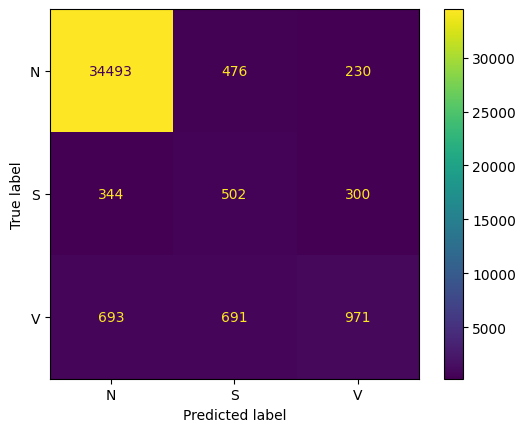

              precision    recall  f1-score   support

           N      0.971     0.980     0.975     35199
           S      0.301     0.438     0.357      1146
           V      0.647     0.412     0.504      2355

    accuracy                          0.929     38700
   macro avg      0.639     0.610     0.612     38700
weighted avg      0.931     0.929     0.928     38700

0.8625105943152456 0.8924351252462709 0.5121390053924506 0.5437574950033311


In [ ]:
# Get predictor
clf = RandomForestClassifier(criterion='gini',
                             n_estimators=50,
                             max_depth=None,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             max_features='sqrt',

                             min_weight_fraction_leaf=0.0,
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=None,
                             random_state=36,
                             verbose=0,
                             warm_start=False,
                             class_weight=None,
                             ccp_alpha=0.0,
                             max_samples=None)

# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(random_state=36)

# clf = SVC(C=1.0,
#         kernel='rbf', # linear ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
#         degree=6,
#         gamma='scale',
#         coef0=0.0,
#         shrinking=True,
#         probability=True,
#         tol=0.001,
#         cache_size=200,
#         class_weight=None,
#         verbose=False,
#         max_iter=- 1,
#         decision_function_shape='ovr',
#         break_ties=False)

exp = ML_experiment(threshold=0.75, reporting=True, mode='multiclass')
exp.main(clf)

predictor = exp.clf

test_GT = np.array([])
test_pred = np.array([])
probabilities = []

for file_name in files_input:
    recording = ML_Test(file_name, predictor=predictor)

    df = recording.initialize_dataframe()

    features_all = ['crop_duration','t_peak','mean','median','std','tvar','skew','kurt',
                                'auc','peak_amplitude','pulse_width','symmetry', 'spectral_entropy','average_energy',
                                'rmssd', 'std_spectrogram',
                                'PTP','A_to_N_ratio']
    features_keep = ['crop_duration','t_peak','median','skew','kurt','auc','pulse_width','symmetry','spectral_entropy','PTP','A_to_N_ratio']

    features_keep_idx = [i for i, feature in enumerate(features_all) if feature in features_keep]

    for i in range(df.shape[0]):
        row_i = df.drop(["peaks", "labels"], axis=1).loc[i:i]
        row_i_zscore = exp.transformer.transform(row_i)[:,features_keep_idx]
        # print(exp.clf.predict(row_i_zscore)[0])

        df.loc[i,'labels'] = exp.clf.predict(row_i_zscore)[0]
        df.loc[i+1,'A_to_N_ratio'] = A_to_N_ratio(df.loc[i:i])[0]

        prob = exp.clf.predict_proba(row_i_zscore)

        # print(prob)

        probabilities.extend(prob)

    test_GT_crop = recording.labels.copy()
    # test_GT_crop[test_GT_crop == 'V'] = 'A'
    # test_GT_crop[test_GT_crop == 'S'] = 'A'

    test_GT = np.concatenate([test_GT, test_GT_crop])
    test_pred = np.concatenate([test_pred, np.array(df.iloc[:-1].labels)])

probabilities = np.array(probabilities)

plot_confusionMatrix(test_GT, test_pred, exp.clf)
print(classification_report(test_GT, test_pred, target_names=clf.classes_, digits=3))

idx_N = np.where(test_pred == 'N')[0]
idx_S = np.where(test_pred == 'S')[0]
idx_V = np.where(test_pred == 'V')[0]

prob_N = probabilities[idx_N, 0]
prob_S = probabilities[idx_S, 1]
prob_V = probabilities[idx_V, 2]
prob_all = np.concatenate([prob_N, prob_S, prob_V])

print(prob_all.mean(), prob_N.mean(), prob_S.mean(), prob_V.mean())


### SVC

Training set size:	72
[54, 17, 96, 119, 103, 57, 24, 8, 89, 80, 39, 16, 121, 48, 106, 44, 11, 49, 117, 91, 98, 33, 9, 114, 90, 110, 104, 85, 5, 27, 52, 18, 58, 50, 86, 101, 21, 19, 20, 109, 42, 25, 84, 26, 47, 102, 112, 14, 22, 46, 118, 94, 15, 37, 105, 2, 32, 23, 115, 87, 81, 7, 56, 38, 10, 45, 108, 34, 41, 31, 116, 6]
Validation set size:	15
[36, 97, 60, 28, 40, 100, 3, 83, 111, 62, 12, 61, 59, 4, 55]
Test set size:		16
[53, 51, 79, 1, 29, 30, 93, 82, 35, 43, 92, 99, 95, 88, 113, 13]
Missing values before outlier removal: 0
Outliers detected (train): 37618
Missing values after outlier removal (train): 37618
Outliers detected (validation): 11026
Missing values after outlier removal (validation): 11026


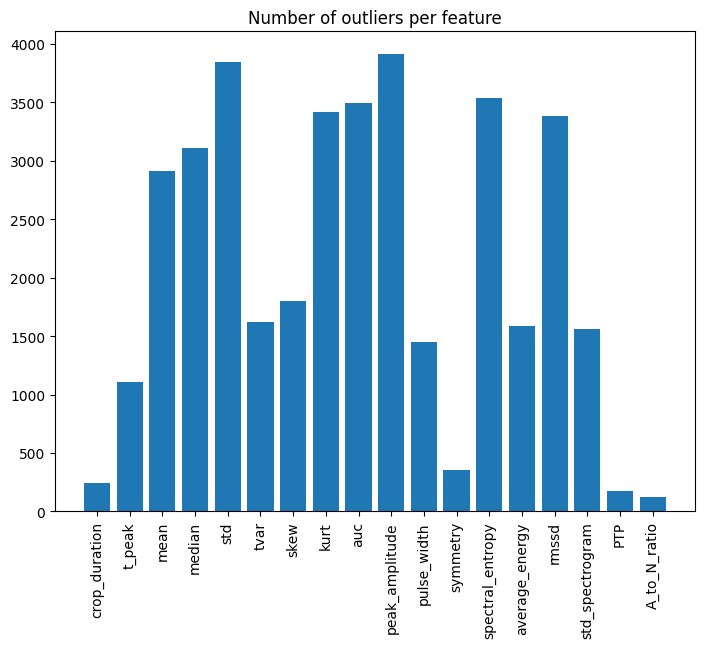

Distribution before subsampling:
148044 4041 5397
26276 711 543
35199 2355 1146

Distribution after subsampling:
labels
S    4041
V    4041
N    4041
Name: count, dtype: int64
labels
V    543
N    543
S    543
Name: count, dtype: int64
labels
N    35199
V     2355
S     1146
Name: count, dtype: int64
Deleted features: {'std_spectrogram', 'tvar', 'peak_amplitude', 'average_energy', 'rmssd', 'mean', 'std'}


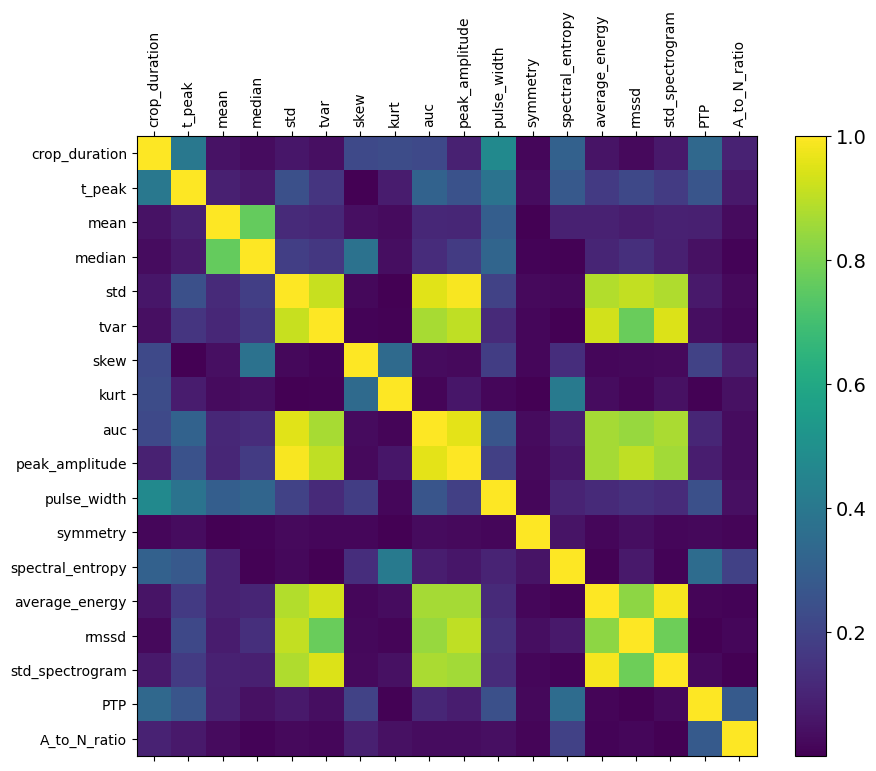

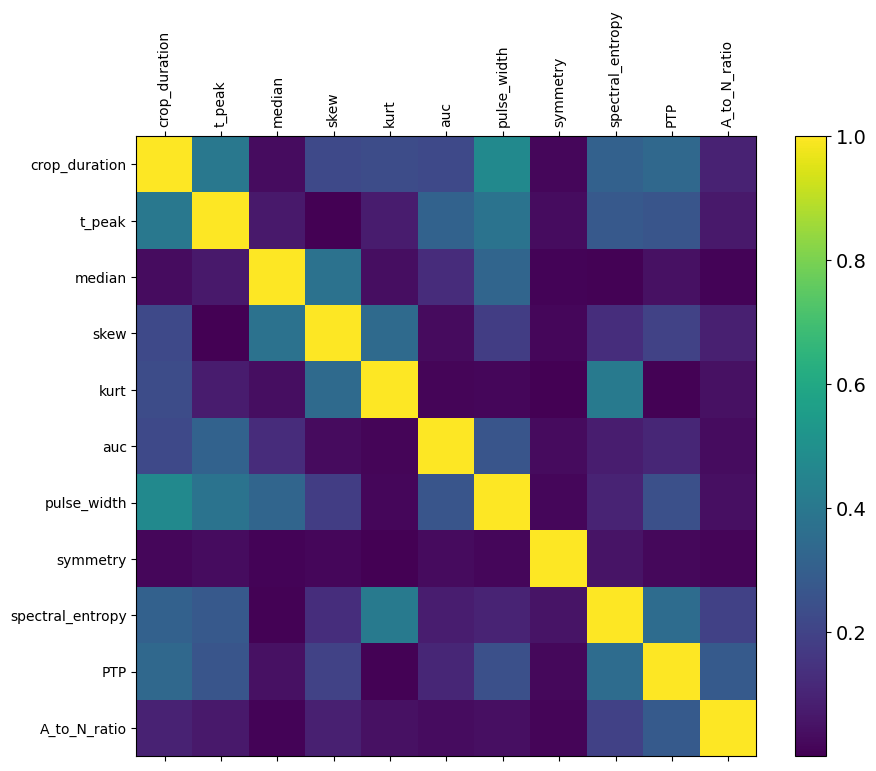

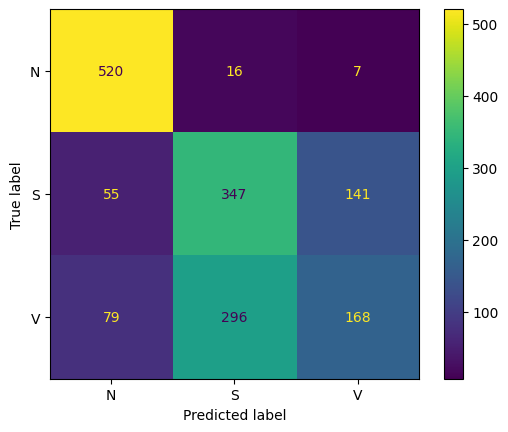

              precision    recall  f1-score   support

           N       0.80      0.96      0.87       543
           S       0.53      0.64      0.58       543
           V       0.53      0.31      0.39       543

    accuracy                           0.64      1629
   macro avg       0.62      0.64      0.61      1629
weighted avg       0.62      0.64      0.61      1629



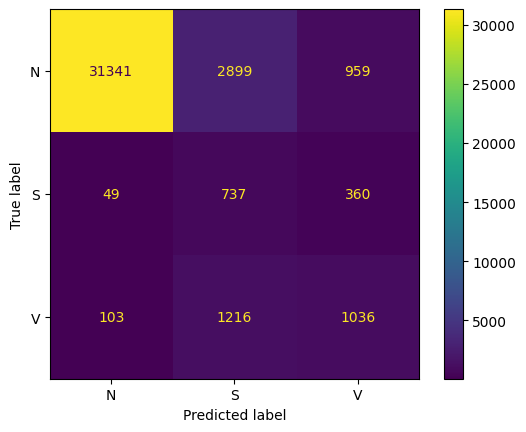

              precision    recall  f1-score   support

           N       1.00      0.89      0.94     35199
           S       0.15      0.64      0.25      1146
           V       0.44      0.44      0.44      2355

    accuracy                           0.86     38700
   macro avg       0.53      0.66      0.54     38700
weighted avg       0.94      0.86      0.89     38700

filtering signal S001_128.mat...
filtering signal S013_128.mat...
filtering signal S029_128.mat...
filtering signal S030_128.mat...
filtering signal S035_128.mat...
filtering signal S043_128.mat...
filtering signal S051_128.mat...
filtering signal S053_128.mat...
filtering signal S079_250.mat...
filtering signal S082_250.mat...
filtering signal S088_250.mat...
filtering signal S092_250.mat...
filtering signal S093_250.mat...
filtering signal S095_250.mat...
filtering signal S099_250.mat...
filtering signal S113_250.mat...


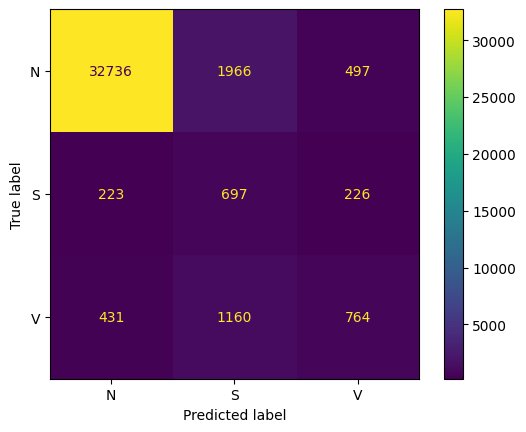

              precision    recall  f1-score   support

           N      0.980     0.930     0.955     35199
           S      0.182     0.608     0.281      1146
           V      0.514     0.324     0.398      2355

    accuracy                          0.884     38700
   macro avg      0.559     0.621     0.544     38700
weighted avg      0.928     0.884     0.901     38700

0.8522246115324434 0.9057685332092132 0.49865908528789477 0.5589155745758623


In [142]:
# Get predictor
# clf = RandomForestClassifier(criterion='gini',
#                              n_estimators=50,
#                              max_depth=None,
#                              min_samples_split=2,
#                              min_samples_leaf=1,
#                              max_features='sqrt',

#                              min_weight_fraction_leaf=0.0,
#                              max_leaf_nodes=None,
#                              min_impurity_decrease=0.0,
#                              bootstrap=True,
#                              oob_score=False,
#                              n_jobs=None,
#                              random_state=36,
#                              verbose=0,
#                              warm_start=False,
#                              class_weight=None,
#                              ccp_alpha=0.0,
#                              max_samples=None)

# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(random_state=36)

clf = SVC(C=1.0,
        kernel='rbf', # linear ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
        degree=6,
        gamma='scale',
        coef0=0.0,
        shrinking=True,
        probability=True,
        tol=0.001,
        cache_size=200,
        class_weight=None,
        verbose=False,
        max_iter=- 1,
        decision_function_shape='ovr',
        break_ties=False)

exp = ML_experiment(threshold=0.75, reporting=True, mode='multiclass')
exp.main(clf)

predictor = exp.clf

test_GT = np.array([])
test_pred = np.array([])
probabilities = []

for file_name in files_input:
    recording = ML_Test(file_name, predictor=predictor)

    df = recording.initialize_dataframe()

    features_all = ['crop_duration','t_peak','mean','median','std','tvar','skew','kurt',
                                'auc','peak_amplitude','pulse_width','symmetry', 'spectral_entropy','average_energy',
                                'rmssd', 'std_spectrogram',
                                'PTP','A_to_N_ratio']
    features_keep = ['crop_duration','t_peak','median','skew','kurt','auc','pulse_width','symmetry','spectral_entropy','PTP','A_to_N_ratio']

    features_keep_idx = [i for i, feature in enumerate(features_all) if feature in features_keep]

    for i in range(df.shape[0]):
        row_i = df.drop(["peaks", "labels"], axis=1).loc[i:i]
        row_i_zscore = exp.transformer.transform(row_i)[:,features_keep_idx]
        # print(exp.clf.predict(row_i_zscore)[0])

        df.loc[i,'labels'] = exp.clf.predict(row_i_zscore)[0]
        df.loc[i+1,'A_to_N_ratio'] = A_to_N_ratio(df.loc[i:i])[0]

        prob = exp.clf.predict_proba(row_i_zscore)

        # print(prob)

        probabilities.extend(prob)

    test_GT_crop = recording.labels.copy()
    # test_GT_crop[test_GT_crop == 'V'] = 'A'
    # test_GT_crop[test_GT_crop == 'S'] = 'A'

    test_GT = np.concatenate([test_GT, test_GT_crop])
    test_pred = np.concatenate([test_pred, np.array(df.iloc[:-1].labels)])

probabilities = np.array(probabilities)

plot_confusionMatrix(test_GT, test_pred, exp.clf)
print(classification_report(test_GT, test_pred, target_names=clf.classes_, digits=3))

idx_N = np.where(test_pred == 'N')[0]
idx_S = np.where(test_pred == 'S')[0]
idx_V = np.where(test_pred == 'V')[0]

prob_N = probabilities[idx_N, 0]
prob_S = probabilities[idx_S, 1]
prob_V = probabilities[idx_V, 2]
prob_all = np.concatenate([prob_N, prob_S, prob_V])

print(prob_all.mean(), prob_N.mean(), prob_S.mean(), prob_V.mean())
